## Creating a dataset of certain size from the scraped files 

Selecting 150 MB of data , change the size in order to generate csv of different sizes

In [ ]:
import os
import csv
import random
import re
import pandas as pd

# Specify the path to your main data directory
data_dir = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/FINAL_PROCESSED"

# Specify the path for the output CSV file
output_csv = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/tokenizer.csv"

target_size = 150 * 1024 * 1024  # 150 MB in bytes
current_size = 0
serial_number = 1
data = []

# Collect all .txt file paths with their folder names
all_files = []
for source_folder in os.listdir(data_dir):
    source_path = os.path.join(data_dir, source_folder)
    if os.path.isdir(source_path):
        for filename in os.listdir(source_path):
            if filename.endswith(".txt"):
                all_files.append((source_folder, os.path.join(source_path, filename)))

# Shuffle file list to ensure random selection
random.shuffle(all_files)

# Iterate over the shuffled list and accumulate text data until target size is reached
for source_folder, file_path in all_files:
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.readlines()

        # Filter out lines with English letters, tags, or URLs
        filtered_lines = [
            re.sub(r'[A-Za-z]', '', line).strip()  # Remove English letters, preserve Malayalam
            for line in text
            if not re.search(r"</?doc>|https?://|<[^>]+>", line)  # Skip lines with tags or URLs
        ]

        # Join the filtered lines back into a single string
        filtered_text = "\n".join(filtered_lines)
        file_size = len(filtered_text.encode("utf-8"))  # Calculate size in bytes of filtered text

        # Check if adding this file would exceed the target size
        if current_size + file_size > target_size:
            break

        # Add file data to the list and update the size
        source_name = f"{source_folder}/{os.path.basename(file_path)}"  # folder and filename as source
        data.append([serial_number, source_name, filtered_text])
        current_size += file_size
        serial_number += 1

# Convert to a DataFrame
df = pd.DataFrame(data, columns=["Serial Number", "Source Name", "Text"])

# Clean the 'Text' column by removing excessive newlines and stripping extra moses
df['Text'] = df['Text'].replace(r'\n+', '\n', regex=True)  # Replace multiple newlines with a single newline
df['Text'] = df['Text'].str.strip()  # Remove leading and trailing moses

# Print the cleaned DataFrame
print(df)

# Write the cleaned data to a CSV file
df.to_csv(output_csv, index=False, encoding="utf-8")

print(f"Cleaned CSV file created at {output_csv} with ~200 MB of data.")


Removing the rows without malayalam content

In [ ]:
import re

# Regular expression to detect Malayalam characters
malayalam_regex = '[\u0D00-\u0D7F]'

# Filter out rows that don't contain Malayalam text
df = df[df['Text'].str.contains(malayalam_regex, regex=True, na=False)]




In [ ]:
# Reset the index and assign new serial numbers
df.reset_index(drop=True, inplace=True)
df['Serial Number'] = df.index + 1  # Start serial numbering from 1



In [ ]:


# Save the updated DataFrame to a CSV file (you can choose your desired output path)
df.to_csv(output_csv, index=False, encoding="utf-8")

print(f"Updated CSV file with new serial numbering saved at {output_csv}.")


Checking the size of csv

In [ ]:
import os

# Path to the CSV file
csv_file_path = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/tokenizer.csv"

# Get the file size in bytes
file_size = os.path.getsize(csv_file_path)

# Convert to MB
file_size_mb = file_size / (1024 * 1024)

print(f"CSV file size: {file_size_mb:.2f} MB")


 Display of the final csv

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df.head()

## Training Tokenizers

In [ ]:
import pandas as pd
pd.reset_option('display.max_colwidth')

In [ ]:
%pip install transformers

In [ ]:
%pip install tokenizers

In [ ]:
import os
from tqdm import tqdm
import time
from tokenizers import SentencePieceBPETokenizer
from transformers import PreTrainedTokenizerFast
import argparse
import datetime
import pandas as pd

In [ ]:
date = datetime.datetime.now().strftime("%Y-%m-%d")
print("Date:", date)

In [ ]:
vocab_size = 16000  # Vocabulary size for tokenizer
data_path = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/tokenizer_150.csv"  
# data_path = "/content/tokenizer_300.csv"
# data_path = "/content/tokenizer_500.csv"

save_path_bpe = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/malayalam_tokenizer_v1"
save_path_unigram = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/malayalam_tokenizer_v2"
save_path_moses = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/malayalam_tokenizer_v3"
save_path_wordpiece = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/malayalam_tokenizer_v4"
save_path_blbpe = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/malayalam_tokenizer_v5"



In [ ]:
bos_tok = "<bos>"
eos_tok = "<eos>"
extra_char = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]


Training the tokenizer - BPE

In [ ]:
import time
import pandas as pd
from tokenizers import SentencePieceBPETokenizer
from transformers import PreTrainedTokenizerFast
from tokenizers import SentencePieceBPETokenizer, normalizers, decoders

def train_tokenizer(data_path = data_path, vocab_size= vocab_size, model_name="./malayalam_tokenizer_v1"):
    st = time.time()
    print(f'Vocabulary size: {vocab_size}')
    print(f"Model save path: {model_name}")

    tokenizer = SentencePieceBPETokenizer()

    # Reading the CSV file (assuming one CSV file)
    df = pd.read_csv(data_path, encoding="utf-8", on_bad_lines='skip')
    print(f"No. of files: {len(df)}")
    text_column = df.iloc[:, 2]  # Accessing the third column which has the text
    special_tokens=["<pad>", "<cls>", "<sep>", "<mask>", "<unk>", "<bos>", "<eos>", "<user>", "<assistant>"]

    # Remove digits or perform other preprocessing
    text_column = text_column.str.replace(r'\d+', '', regex=True)
    text_column = text_column.apply(lambda x: f"{special_tokens[0]} {x} {special_tokens[1]}")  # Adding <bos> at the start and <eos> at the end of each sentence

    try:
        tokenizer.train_from_iterator(
            text_column,  # Pass the text column to train the tokenizer
            vocab_size=vocab_size,
            min_frequency=5,
            special_tokens=["<pad>", "<cls>", "<sep>", "<mask>", "<unk>", "<bos>", "<eos>", "<user>", "<assistant>"],
            show_progress=True,
        )
    except Exception as e:
        print("Error in training tokenizer:", e)
        print(f"Training interrupted after {(time.time() - st) / 60:.2f} minutes")

    print(f"Completed tokenizer training.")

    et = time.time()
    print(f"Training completed in {(et - st) / 60:.2f} minutes")

    # Setup transformer-compatible tokenizer after the training is completed
    transformer_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        bos_token="<bos>",
        eos_token="<eos>",
        unk_token="<unk>",
        pad_token="<pad>",
        mask_token="<mask>",
        additional_special_tokens=["<user>", "<assistant>"],
    )
    transformer_tokenizer.backend_tokenizer.normalizer = normalizers.Replace(' ', '▁')
    transformer_tokenizer.backend_tokenizer.pre_tokenizer = None
    transformer_tokenizer.backend_tokenizer.decoder = decoders.Replace('▁', ' ')

    # Save the transformer-compatible tokenizer
    transformer_tokenizer.save_pretrained(model_name)
    print(f"Saved tokenizer to {model_name}")

# Call the function to train the tokenizer
train_tokenizer(data_path = data_path, vocab_size = vocab_size, model_name=save_path_bpe)


Training the tokenizer - Unigram

In [ ]:
import os
import time
import pandas as pd
from tokenizers import Tokenizer, normalizers, decoders,trainers
from tokenizers.models import Unigram
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast

# Read the CSV file with UTF-8 encoding
df = pd.read_csv(data_path, encoding='utf-8')

# Ensure correct column indexing
print(df.head())  # Optionally print the first few rows to confirm the content

# Special tokens
bos_tok = "<bos>"
eos_tok = "<eos>"
extra_char = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "#", "##", "###", "౦", "౧", "౨", "౩", "౪", "౫", "౬", "౭", "౮", "౯"]

# Step 1: Train Unigram Tokenizer
def train_tokenizer(df, vocab_size= vocab_size, model_name= "./malayalam_tokenizer_v2"):
    st = time.time()
    print(f'Vocab size: {vocab_size}')
    print(f"Model name : {model_name}")

    # Initialize Unigram model
    unigram_model = Unigram()

    unigram_tokenizer = Tokenizer(unigram_model)
    unigram_tokenizer.pre_tokenizer = Whitespace()
    trainer = trainers.UnigramTrainer(
        vocab_size=vocab_size,
        special_tokens=["<pad>", "<cls>", "<sep>", eos_tok, "<mask>", "<unk>", bos_tok, "<user>", "<assistant>"] + extra_char,
        unk_token="<unk>",
        min_frequency=5,
    )
    # Fetch text data from the 3rd column (index 2)
    df_text = df.iloc[:, 2].dropna()  # Change to column index 2 for the third column
    df_text = df_text.str.replace(r'\d+', '', regex=True)  # Remove numbers
    text_data = df_text.tolist()  # Convert to a list of strings

    print(f"Training on {len(text_data)} entries")  # Debugging output

    try:
        unigram_tokenizer.train_from_iterator(
            iter(text_data),  # Ensure it's an iterator
            trainer=trainer)
    except Exception as e:
        print(f"Error in training tokenizer: {e}")
        print(f"Trained for {(time.time() - st) / 60:.2f} minutes")
        return  # Exit the function if an error occurs

    et = time.time()
    print(f"Trained {model_name} in {(et - st) / 60:.2f} minutes")

    # Save the tokenizer model
    os.makedirs(model_name, exist_ok=True)  # Create the directory if it doesn't exist
    unigram_tokenizer.save(f"{model_name}/tokenizer.json")
    print(f"Saved Unigram tokenizer to {model_name}")

    # Convert to transformers format
    transformer_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=unigram_tokenizer,
        bos_token=bos_tok,
        eos_token=eos_tok,
        unk_token="<unk>",
        pad_token="<pad>",
        mask_token="<mask>",
        padding_side="left",
        truncation_side="right",
        additional_special_tokens=["<user>", "<assistant>"],
        clean_up_tokenization_spaces=False,
    )

    transformer_tokenizer.backend_tokenizer.normalizer = normalizers.Replace(' ', '▁')
    transformer_tokenizer.backend_tokenizer.pre_tokenizer = None
    transformer_tokenizer.backend_tokenizer.decoder = decoders.Replace('▁', ' ')

    transformer_tokenizer.save_pretrained(model_name)
    print(f"Saved tokenizer model to {model_name} in {(time.time() - et) / 60:.2f} minutes")

# Call the function to train the tokenizer
train_tokenizer(df, vocab_size=vocab_size, model_name= save_path_unigram)


Training the tokenizer - Moses

In [ ]:
import time
import pandas as pd
from tokenizers import SentencePieceBPETokenizer
from transformers import PreTrainedTokenizerFast
from sacremoses import MosesTokenizer

def train_tokenizer(data_path= data_path, vocab_size=16000, model_name="./malayalam_tokenizer_v3"):
    st = time.time()
    print(f'Vocabulary size: {vocab_size}')
    print(f"Model save path: {model_name}")
    
    # Initialize the trainable tokenizer
    tokenizer = SentencePieceBPETokenizer()
    
    # Reading the CSV file
    df = pd.read_csv(data_path)
    print(f"No. of files: {len(df)}")
    text_column = df.iloc[:, 2]  # Accessing the third column which has the text
    special_tokens = ["<pad>", "<cls>", "<sep>", "<mask>", "<unk>", "<bos>", "<eos>", "<user>", "<assistant>"]
           
    # Preprocess with MosesTokenizer (optional)
    moses_tokenizer = MosesTokenizer(lang="ml")  # Set language code as "ml" for Malayalam
    text_column = text_column.str.replace(r'\d+', '', regex=True)  # Remove digits
    text_column = text_column.apply(lambda x: " ".join(moses_tokenizer.tokenize(x)))  # Apply Moses Tokenizer

    # Add special tokens
    text_column = text_column.apply(lambda x: f"{special_tokens[5]} {x} {special_tokens[6]}")  # Adding <bos> and <eos>

    try:
        tokenizer.train_from_iterator(
            text_column,  # Pass the text column to train the tokenizer
            vocab_size=vocab_size,
            min_frequency=5,
            special_tokens=special_tokens,
            show_progress=True,
        )
    except Exception as e:
        print("Error in training tokenizer:", e)
        print(f"Training interrupted after {(time.time() - st) / 60:.2f} minutes")
        return

    print(f"Completed tokenizer training.")

    et = time.time()
    print(f"Training completed in {(et - st) / 60:.2f} minutes")

    # Setup transformer-compatible tokenizer after training
    transformer_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        bos_token="<bos>",
        eos_token="<eos>",
        unk_token="<unk>",
        pad_token="<pad>",
        mask_token="<mask>",
        additional_special_tokens=["<user>", "<assistant>"],
    )
    
    # Save the transformer-compatible tokenizer
    transformer_tokenizer.save_pretrained(model_name)
    print(f"Saved tokenizer to {model_name}")

# Call the function to train the tokenizer
train_tokenizer(data_path=data_path, vocab_size=vocab_size, model_name=save_path_moses)

Training the tokenizer - Wordpiece

In [ ]:
import os
import time
import pandas as pd
from tokenizers import BertWordPieceTokenizer
from transformers import PreTrainedTokenizerFast

def train_wordpiece_tokenizer(data_path, vocab_size=16000, model_name=save_path_wordpiece):
    st = time.time()
    print(f"Vocabulary size: {vocab_size}")
    print(f"Model save path: {model_name}")

    tokenizer = BertWordPieceTokenizer(
        clean_text=True,
        handle_chinese_chars=False,
        strip_accents=False,
        lowercase=True,
    )

    # Reading the CSV file
    df = pd.read_csv(data_path)
    print(f"No. of files: {len(df)}")
    text_column = df.iloc[:, 2]  # Accessing the third column which has the text
    special_tokens = ["[PAD]", "[CLS]", "[SEP]", "[MASK]", "[UNK]", "[BOS]", "[EOS]", "[USER]", "[ASSISTANT]"]

    # Preprocess the text
    text_column = text_column.str.replace(r'\d+', '', regex=True)
    text_column = text_column.apply(lambda x: f"{special_tokens[5]} {x} {special_tokens[6]}")  # Adding <bos> and <eos>

    try:
        tokenizer.train_from_iterator(
            text_column,
            vocab_size=vocab_size,
            min_frequency=5,
            special_tokens=special_tokens,
            show_progress=True,
        )
    except Exception as e:
        print("Error in training tokenizer:", e)
        print(f"Training interrupted after {(time.time() - st) / 60:.2f} minutes")

    print("Completed tokenizer training.")

    # Create the directory if it doesn't exist
    os.makedirs(model_name, exist_ok=True)

    # Save the tokenizer as a fast tokenizer
    # Convert BertWordPieceTokenizer to PreTrainedTokenizerFast
    fast_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        unk_token="[UNK]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        sep_token="[SEP]",
        mask_token="[MASK]",
        bos_token="[BOS]",
        eos_token="[EOS]"
    )

    # Save the tokenizer
    fast_tokenizer.save_pretrained(model_name)
    print(f"Saved tokenizer to {model_name}")

    et = time.time()
    print(f"Training completed in {(et - st) / 60:.2f} minutes")

# Call the function to train the tokenizer
train_wordpiece_tokenizer(data_path= data_path, vocab_size= vocab_size)

Training the tokenizer - byte level bpe

In [ ]:
import time
import pandas as pd
from tokenizers import ByteLevelBPETokenizer, normalizers, decoders, pre_tokenizers

from transformers import PreTrainedTokenizerFast

def train_tokenizer(data_path, vocab_size, model_name="./malayalam_tokenizer_v5"):
    st = time.time()
    print(f'Vocabulary size: {vocab_size}')
    print(f"Model save path: {model_name}")

    # Initialize the ByteLevelBPETokenizer
    tokenizer = ByteLevelBPETokenizer()

    # Setup normalizer to replace spaces with '▁' (common in byte-level tokenization)
    tokenizer.normalizer = normalizers.Replace(' ', '▁')

    # Setup decoder for byte-level tokens
    tokenizer.decoder = decoders.ByteLevel()

    # Setup pre-tokenizer to split input at byte-level
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()


    # Reading the CSV file (assuming one CSV file)
    df = pd.read_csv(data_path, encoding="utf-8", on_bad_lines='skip')
    print(f"No. of files: {len(df)}")
    text_column = df.iloc[:, 2]  # Accessing the third column which has the text
    special_tokens = ["<pad>", "<cls>", "<sep>", "<mask>", "<unk>", "<bos>", "<eos>", "<user>", "<assistant>"]

    # Remove digits or perform other preprocessing
    text_column = text_column.str.replace(r'\d+', '', regex=True)
    text_column = text_column.apply(lambda x: f"{special_tokens[0]} {x} {special_tokens[1]}")  # Adding <bos> at the start and <eos> at the end of each sentence

    # Train the ByteLevelBPETokenizer on the given data
    try:
        tokenizer.train_from_iterator(
            text_column,  # Pass the text column to train the tokenizer
            vocab_size=vocab_size,
            min_frequency=5,
            special_tokens=special_tokens,
            show_progress=True,
        )
    except Exception as e:
        print("Error in training tokenizer:", e)
        print(f"Training interrupted after {(time.time() - st) / 60:.2f} minutes")

    print(f"Completed tokenizer training.")

    et = time.time()
    print(f"Training completed in {(et - st) / 60:.2f} minutes")

    # Setup transformer-compatible tokenizer after the training is completed
    transformer_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        bos_token="<bos>",
        eos_token="<eos>",
        unk_token="<unk>",
        pad_token="<pad>",
        mask_token="<mask>",
        additional_special_tokens=["<user>", "<assistant>"],
    )

    # Save the transformer-compatible tokenizer
    transformer_tokenizer.save_pretrained(model_name)
    print(f"Saved tokenizer to {model_name}")

# Call the function to train the tokenizer
train_tokenizer(data_path = data_path, vocab_size = vocab_size, model_name=save_path_blbpe)


Testing the tokenizers on single sentence

In [ ]:
from transformers import PreTrainedTokenizerFast

tokenizer_bpe = PreTrainedTokenizerFast.from_pretrained('/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing//malayalam_tokenizer_v1')
tokenizer_unigram = PreTrainedTokenizerFast.from_pretrained('/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing//malayalam_tokenizer_v2')
tokenizer_moses = PreTrainedTokenizerFast.from_pretrained('/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing//malayalam_tokenizer_v3')
tokenizer_wordpiece = PreTrainedTokenizerFast.from_pretrained('/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing//malayalam_tokenizer_v4')
tokenizer_blbpe = PreTrainedTokenizerFast.from_pretrained('/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/malayalam_tokenizer_v5')

# Sample Malayalam text
sample_text = "ഹലോ, എനിക്ക് മലയാളം വളരെ ഇഷ്ടമാണ്!"


testing bpe

In [ ]:
# Tokenize the sample text
tokens = tokenizer_bpe.tokenize(sample_text)
token_ids = tokenizer_bpe.convert_tokens_to_ids(tokens)

# Print the tokens and their corresponding token IDs
print(f"Original Text: {sample_text}")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

# Detokenize the token IDs back to text
detokenized_text = tokenizer_bpe.decode(token_ids)
print(f"Detokenized Text : {detokenized_text}")


testing unigram

In [ ]:
# Tokenize the sample text
tokens = tokenizer_unigram.tokenize(sample_text)
token_ids = tokenizer_unigram.convert_tokens_to_ids(tokens)

# Print the tokens and their corresponding token IDs
print(f"Original Text: {sample_text}")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

# Detokenize the token IDs back to text
detokenized_text = tokenizer_unigram.decode(token_ids)
print(f"Detokenized Text : {detokenized_text}")

testing moses

In [ ]:
# Tokenize the sample text
tokens = tokenizer_moses.tokenize(sample_text)
token_ids = tokenizer_moses.convert_tokens_to_ids(tokens)

# Print the tokens and their corresponding token IDs
print(f"Original Text: {sample_text}")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

# Detokenize the token IDs back to text
detokenized_text = tokenizer_moses.decode(token_ids)
print(f"Detokenized Text : {detokenized_text}")

testing wordpiece

In [ ]:
# Tokenize the sample text
tokens = tokenizer_wordpiece.tokenize(sample_text)
token_ids = tokenizer_wordpiece.convert_tokens_to_ids(tokens)

# Print the tokens and their corresponding token IDs
print(f"Original Text: {sample_text}")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

# Detokenize the token IDs back to text
detokenized_text = tokenizer_wordpiece.decode(token_ids)
print(f"Detokenized Text : {detokenized_text}")

testing blbpe

In [ ]:
# Tokenize the sample text

tokens = tokenizer_blbpe.tokenize(sample_text)
token_ids = tokenizer_blbpe.convert_tokens_to_ids(tokens)

# Print the tokens and their corresponding token IDs
print(f"Original Text: {sample_text}")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

# Detokenize the token IDs back to text
detokenized_text = tokenizer_blbpe.decode(token_ids)
print(f"Detokenized Text : {detokenized_text}")

## Fertility Score

In [ ]:
from tokenizers import Tokenizer
import numpy as np


In [ ]:
tokenizer_path_bpe = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/malayalam_tokenizer_v1/tokenizer.json"
tokenizer_path_unigram = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/malayalam_tokenizer_v2/tokenizer.json"
tokenizer_path_moses = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing//malayalam_tokenizer_v3/tokenizer.json"
tokenizer_path_wordpiece = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/malayalam_tokenizer_v4/tokenizer.json"
tokenizer_path_blbpe = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/malayalam_tokenizer_v5/tokenizer.json"

data_path = "/Users/heerkubadia/Desktop/Sem - 5/Natural Language Processing/tokenizer_150.csv"
column_name = 'Text'

In [ ]:
tokenizer_bpe = Tokenizer.from_file(tokenizer_path_bpe)
tokenizer_unigram = Tokenizer.from_file(tokenizer_path_unigram)
tokenizer_moses = Tokenizer.from_file(tokenizer_path_moses)
tokenizer_wordpiece = Tokenizer.from_file(tokenizer_path_wordpiece)
tokenizer_blbpe = Tokenizer.from_file(tokenizer_path_blbpe)


In [ ]:
pip install git+https://github.com/anoopkunchukuttan/indic_nlp_library.git


In [ ]:
from indicnlp.tokenize import indic_tokenize

In [ ]:
def calculate_fertility_score(data_path, tokenizer):
    # Read the data (assuming it's a CSV file)
    df = pd.read_csv(data_path)
    text_column = df.iloc[:, 2]  # Assuming the text is in the 3rd column

    # Get word count in documents (using basic word tokenization for counting words)
    df_word_count = []
    for sentence in text_column:
        tokens = indic_tokenize.trivial_tokenize(sentence)  # Tokenizing using indicnlp
        df_word_count.append(len(tokens)) # Simple split for word count
    np_word_count = np.array(df_word_count)

    # Tokenize the documents using your trained tokenizer
    df_token_count = []
    for sentence in text_column:
        tokenized_output = tokenizer.encode(sentence)  # Tokenize the sentence
        df_token_count.append(len(tokenized_output.tokens))  # Count the tokens
    np_token_count = np.array(df_token_count)

    # Calculate the fertility score
    fertility_score = np.mean(np_token_count / np_word_count)

    # Save the fertility score to a file
    with open("fertility_score.txt", "w") as file:
        file.write(str(fertility_score))

    print(f"Fertility score: {fertility_score}")
    return fertility_score


fertility score of bpe

In [ ]:

calculate_fertility_score(data_path= data_path, tokenizer=tokenizer_bpe)

fertility score of unigram

In [ ]:

calculate_fertility_score(data_path= data_path, tokenizer=tokenizer_unigram)

fertility score of moses

In [ ]:
import numpy as np
def calculate_fertility_score(data_path, tokenizer):
    # Read the data (assuming it's a CSV file)
    df = pd.read_csv(data_path)
    text_column = df.iloc[:, 2]  # Assuming the text is in the 3rd column

    # Get word count in documents (using basic word tokenization for counting words)
    df_word_count = []
    for sentence in text_column:
        tokens = indic_tokenize.trivial_tokenize(sentence)  # Tokenizing using indicnlp
        df_word_count.append(len(tokens)) # Simple split for word count
    np_word_count = np.array(df_word_count)

    # Tokenize the documents using your trained tokenizer
    df_token_count = []
    for sentence in text_column:
        tokenized_output = tokenizer.encode(sentence)  # Tokenize the sentence
        df_token_count.append(len(tokenized_output))  # Count the number of tokens directly

    np_token_count = np.array(df_token_count)

    # Calculate the fertility score
    fertility_score = np.mean(np_token_count / np_word_count)

    # Save the fertility score to a file
    with open("fertility_score.txt", "w") as file:
        file.write(str(fertility_score))

    print(f"Fertility score: {fertility_score}")
    return fertility_score

# Call the function with the path to your data
calculate_fertility_score(data_path=data_path, tokenizer=tokenizer_moses)

fertility score of wordpiece

In [ ]:

calculate_fertility_score(data_path= data_path, tokenizer=tokenizer_wordpiece)

fertility score of blbpe

In [ ]:

calculate_fertility_score(data_path= data_path, tokenizer=tokenizer_blbpe)

## Matrix representing the fertility scores of various tokenizers on different dataset sizes

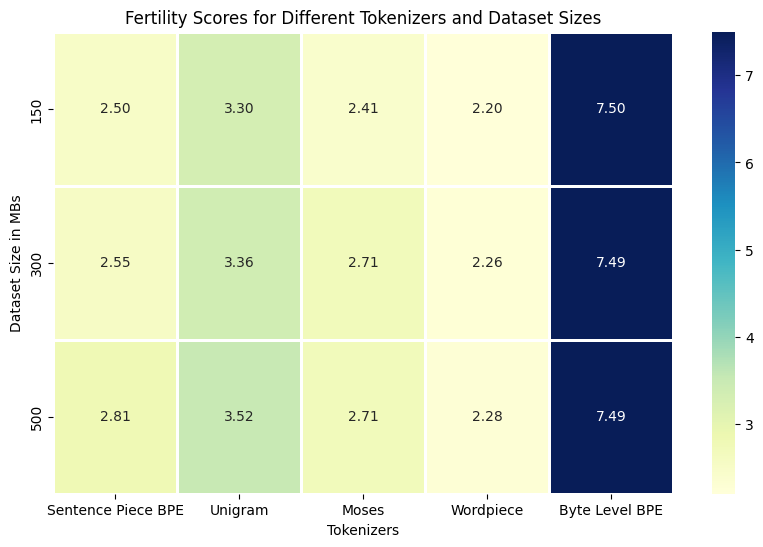

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example dataset of different tokenizers, dataset sizes, and corresponding fertility scores
data = {
    'Sentence Piece BPE': [2.5, 2.55,2.81],
    'Unigram': [3.3, 3.36,3.52],
    'Moses': [2.41,2.71,2.71],
    'Wordpiece': [2.2, 2.26,2.28],
    'Byte Level BPE' :[7.5, 7.49,7.49]
}

# Corresponding dataset sizes (could be number of sentences or text samples)
dataset_sizes = [150, 300, 500]

# Create a DataFrame from the data
df = pd.DataFrame(data, index=dataset_sizes)

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, linewidths=1)

# Add labels and title
plt.title("Fertility Scores for Different Tokenizers and Dataset Sizes")
plt.xlabel("Tokenizers")
plt.ylabel("Dataset Size in MBs")

# Show the plot
plt.show()
